# Kepler objects of interest

For this workshop, we will be using the methods we previously learned to identify periodicity (either exoplanets or eclipsing binaries) in lightcurves from the Kepler space telescope. Kepler stared at the same patch of the sky for years, observing the same stars with a regular cadence of 30 minutes (a subset were observed with a faster cadence). Every few weeks, Kepler would rotate to Earth to beam back down the data it collected. Then it would return to the same field to repeat its observations. 

The long light curves therefore show gaps in the data. To use Fourier methods with these data, one would need to fill in the gaps with padded data. Fortunately, we are only looking at a small subset of the data, so no large gaps should be present. 

In [1]:
# First, let's load our necessary notebooks.
import numpy as np
import matplotlib.pyplot as plt

# The Kepler data is stored as fits files. We will use astropy.io.fits to deal with these data
from astropy.io import fits

%matplotlib inline

### Load up a light curve from Kepler

In [2]:
# This command loads all the data into a list. We will select the first object, KIC6891512
hdulist = fits.open("data/kplr006891512-2009166044711_slc.fits")

In [3]:
# There are other useful data in hdulist, but here we are principally focused on the lightcurve data only. 
# These are found in index "1" of hdulist

# We will not be using the header, but in case you need it, this is how it is stored
header = hdulist[1].header

# For easy access, we will create a variable called "data" that points to the Kepler lightcurve data
data = hdulist[1].data

In [4]:
# Let's look at what information is contained in "data"
print(data.dtype.names)

('TIME', 'TIMECORR', 'CADENCENO', 'SAP_FLUX', 'SAP_FLUX_ERR', 'SAP_BKG', 'SAP_BKG_ERR', 'PDCSAP_FLUX', 'PDCSAP_FLUX_ERR', 'SAP_QUALITY', 'PSF_CENTR1', 'PSF_CENTR1_ERR', 'PSF_CENTR2', 'PSF_CENTR2_ERR', 'MOM_CENTR1', 'MOM_CENTR1_ERR', 'MOM_CENTR2', 'MOM_CENTR2_ERR', 'POS_CORR1', 'POS_CORR2')


### Plot the lightcurve

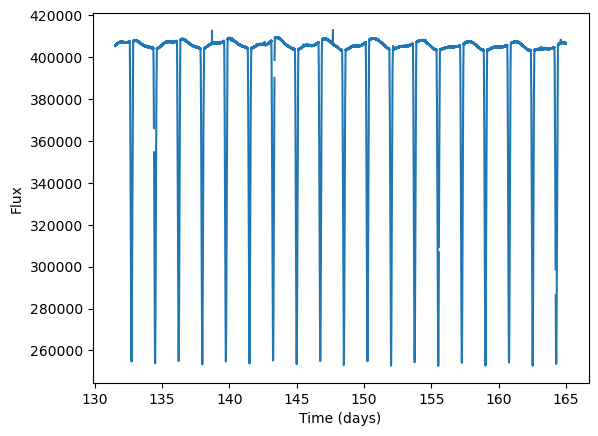

In [5]:
plt.plot(data['Time'], data['SAP_FLUX'])

plt.xlabel('Time (days)')
plt.ylabel('Flux')

plt.show()

## Your task: find the periodicity in the above light curve

Look at the light curve above. The eclipses are __glaring__!! The flux deficit is too large to be a planet; this is an eclipsing binary. What is the orbital period of this binary? Use either or both of the tools you learned in the previous session to find the periodicity.

Since Kepler data (as great as it may be) is imperfect, we will need to first remove any NaN's from the data. There are several ways of doing this. I have provided some code to replace any NaN values with the average flux of the system. This will introduce some noise to the data, which is acceptable for the sake of this exercise.

After this code block, use your code to generate a periodogram or power spectrum and find the orbital period of the system.

In [6]:
idx_nan = np.where(np.isnan(data['SAP_FLUX']))[0]
idx_not_nan = np.where(~np.isnan(data['SAP_FLUX']))[0]

flux_average = np.average(data['SAP_FLUX'][idx_not_nan])

data['SAP_FLUX'][idx_nan] = flux_average

### Periodogram

Copy code from the Time_Series_S notebook to create a periodogram of the light curve data below.

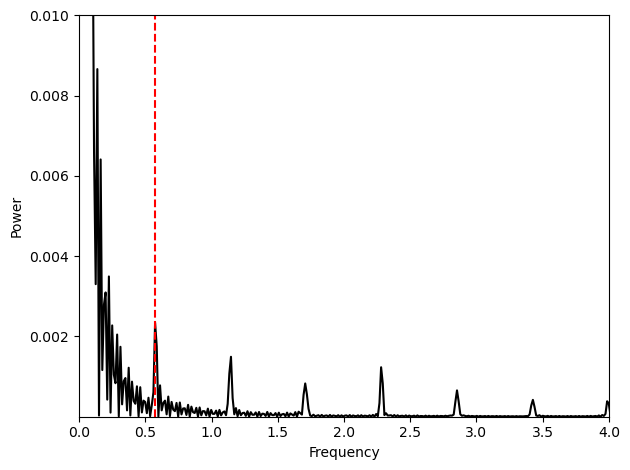

In [7]:
from scipy.signal import lombscargle

freq_max = 25
N_freq_test = 2000

# do not change these...
frequencies = np.linspace(0.1, freq_max, N_freq_test)
angular_frequencies = 2 * np.pi * frequencies




# create the periodograms
periodogram = lombscargle(data['TIME'], data['SAP_FLUX'], angular_frequencies, normalize=True)

# Plot the periodogram
plt.plot(frequencies, periodogram, color="k")


# Make the plot pretty
plt.xlabel('Frequency')
plt.ylabel('Power')


plt.xlim(0, 4)
plt.ylim(1.0e-10, 1.0e-2)


# Plot the correct frequency
plt.axvline(2.0/3.505, color='r', linestyle='dashed')


plt.tight_layout()
plt.show()

### Fourier Transform

Copy code from the Time_Series_S notebook to run a discrete Fourier transform of the light curve data below.

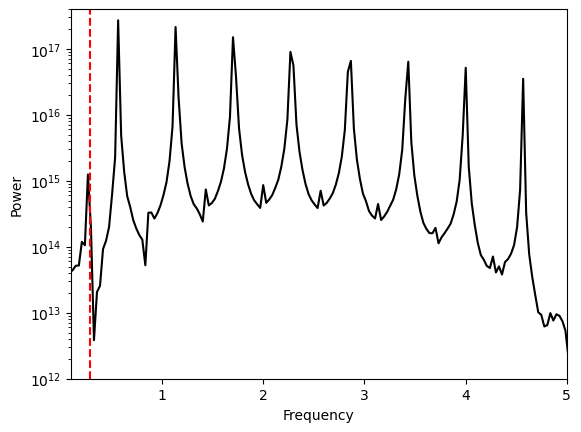

In [8]:
# This gives us the fourier transform - it is a power for every frequency
DFT = np.fft.fft(data['SAP_FLUX'])

# This gives us the frequencies associated with each fourier transform power
sample_spacing = data['Time'][1]-data['Time'][0]
# obs_length = np.max(data['Time']) - np.min(data['Time'])


freq = np.fft.fftfreq(data['SAP_FLUX'].size, sample_spacing)



# Plot the fourier transform power as a function of the frequency
half = len(data['SAP_FLUX']) // 2
plt.plot(freq[:half], np.abs(DFT[:half])**2, color='k')

plt.xlim(0.1, 5.0)
# plt.xlim(1, 100)
plt.ylim(1.0e12, 4.0e17)
plt.yscale('log')

# plt.axvline(1.0/2.205, color='r', linestyle='dashed')
plt.axvline(1.0/3.505, color='r', linestyle='dashed')


plt.xlabel('Frequency')
plt.ylabel('Power')

plt.show()

For some light curves, the Fourier transforms and periodograms produce multiple peaks at different frequencies. How do we tell which one is the correct peak? We can check by folding the lightcurves over the different possible periods. Use the function coded below to check possible periodicities.

In [9]:
def plot_folded_light_curve(time, flux, period):
    """ Function to fold, then plot a light curve over a specific period
    
    Parameters
    ----------
    time : float
        Time data
    flux : float
        Flux data
    period : float
        Period to fold a lightcurve
        
    Returns
    -------
    Plot a folded light curve
    
    """
    
    # Create a time-like axis, but folded over the period
    time_folded = np.copy(time)
    time_folded = time_folded - np.min(time)
    time_folded = time_folded % period
    orbital_phase = time_folded/period
        
    # Plot the data with the orbital phase on the x-axis
    plt.scatter(orbital_phase, flux, marker='.', rasterized=True)
    
    # Make the plot pretty
    plt.xlabel('Orbital Phase')
    plt.ylabel('Flux')
    
    plt.show()

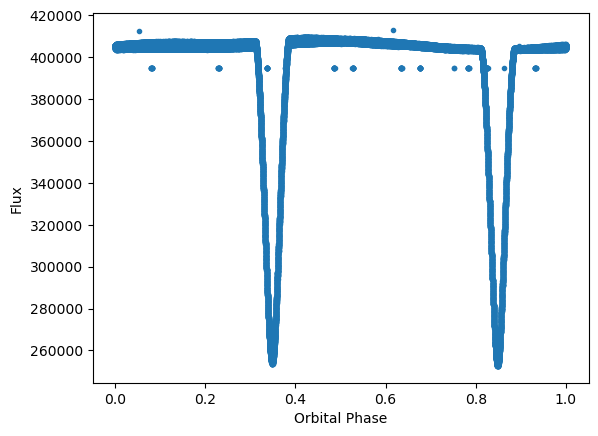

In [10]:
# Plot the folded light curve
test_period = 3.505/1.0

plot_folded_light_curve(data['TIME'], data['SAP_FLUX'], test_period)

### Discuss with your partner

If you go back to the Fourier transform and periodogram and replace the line `plt.axvline(1.0/3.505, color='r', linestyle='dashed')` with `plt.axvline(2.0/3.505, color='r', linestyle='dashed')`, you will find the line now matches with the best-fit peak; the best fit frequency is two times the correct binary period. Why do we get the wrong period???

## Other Kepler objects of interest

With your partner, load up other Kepler objects of interest and see if you can identify other periodic or non-periodic signals.